In [13]:
import sqlite3
import string
import pandas as pd

from scipy.signal import find_peaks
import re
from urllib.request import urlopen

from io import TextIOWrapper
import time
import os.path
from os import path
from queue import PriorityQueue
from itertools import combinations
from numpy.random import choice
import random
import sqlite3

#setting up actual dataset sequences for Fragoza to embed
import pandas as pd
import sys
import time
from Bio import Entrez
import xml.etree.ElementTree as ET
import os.path
from os import path
import itertools
import pickle
import copy
import re
from Bio.SeqIO import *
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np


In [14]:
#looking at intersection of ppiDB and the Fragoza proteins 

#actual Sqlite code for the database now
dbName = "interactionDB.sqlite3"
DEFAULT_PATH = os.path.join(os.path.dirname("../"), dbName)

def db_connect(db_path=DEFAULT_PATH):
    con = sqlite3.connect(db_path)
    return con


In [33]:
#functions to get list of ids from sequences 
 
def getIDs(proList):
    #returns list of database ids where possible
    ids = []
    foundIds = 0
    notFound = 0
    multiMatch = 0
    conn = db_connect()
    cur = conn.cursor()
    for seq in proList:
        cur.execute("SELECT * FROM proteins WHERE sequence=?", (seq,))
        found =  cur.fetchall()
        if len(found) == 0: #not found 
            notFound += 1
        elif len(found) == 1:
            foundIds += 1
            ids.append(found[0])
        else:
            multiMatch += 1
    print ("found: ", foundIds, " not found: ", notFound, " mutli match: ", multiMatch)
    print ("total: ",len(proList))
    return ids 

def openFasta(fastaName):
    record = SeqIO.read(fastaName, "fasta")
    return str(record.seq)


def mutateSequence(fastaName, mutation):
    # opens FASTA and mutates sequence, saves mutated Fasta in same folder
    # open FASTA
    record = SeqIO.read(fastaName, "fasta")
    sequenceToMutate = str(record.seq)
    halves = mutation.split(",")
    actualMutation = halves[1]
    firstAA = actualMutation[0]
    mutAA = actualMutation[len(actualMutation) - 1]
    number = int(actualMutation[1:len(actualMutation) - 1])
    # check that the AA at that position is correct
    # print ("len seq: ", len(sequenceToMutate))
    # print ("actualMutation: ", actualMutation)
    # print ("number: ", number)
    if number - 1 <= len(sequenceToMutate):
        # print ("at pos: ", sequenceToMutate[number - 1])
        if firstAA == sequenceToMutate[number - 1]:
            # print ("mutating")
            index = number - 1
            newSeq = sequenceToMutate[:index] + mutAA + sequenceToMutate[index + 1:]
            return newSeq
        else:
            return -1
    else:
        return -1

def flipDisruption(disr):
    if disr == 1:
        return 0
    else:
        return 1

def getFragozaSequencesDFs():
    #returns csv of interactions and sequences below <= 2000 AA
    # attaching NP to each row
    origDatasetDtypes = {
        "Chrom": str,
        "Pos": float,
        "dbSNP_id": str,
        "Mutation": str,
        "AF_all": float,
        "Target Entrez GeneID": str,
        "HGVS_cDNA": str,
        "UniProt": str,
        "Interactor Entrez GeneID": str,
        "Disruption": float,
    }
    # print (origDatasetDtypes)
    origDataset = pd.read_csv("41467_2019_11959_MOESM6_ESM.csv", sep=',')
    origDataset = origDataset.astype(origDatasetDtypes)

    origDataset['transcript'] = origDataset.apply(lambda row: row['HGVS_cDNA'].split(':')[0], axis=1)
    origDataset['mutationAA'] = origDataset.apply(lambda row: row['UniProt'].split(',')[1], axis=1)

    openedKey = pd.read_csv("transcriptProteinTableFragoza.csv")
    merged = pd.merge(origDataset, openedKey, how='left', on='transcript')
    merged['saveIDTarget'] = merged['Target Entrez GeneID'] + "_" + merged['mutationAA']
    print ("intermed length: ", merged.shape) #(4109, 15)
    seqTable = {"ID": [], "Seq": [], 'Len': [], 'Type':[]}
    # saveIDTarget (mutation partner) mut id
    # "Interactor Entrez GeneID" other
    print(merged.iloc[0])
    badMutants = []
    for i, row in merged.iterrows():
        # open orig FASTA
        origID = row['Target Entrez GeneID']
        mutation = row['mutationAA']
        np = row['product']
        fastaFolder = './FragozaFastas/'
        mutationU = row['UniProt']
        saveID = row['saveIDTarget']
        fastaName = fastaFolder + np + ".fa"
        newSeq = mutateSequence(fastaName, mutationU)
        wtSeq = openFasta(fastaName)
        if not newSeq == -1:
            seqTable["ID"].append(saveID)
            seqTable["Seq"].append(newSeq)
            seqTable['Len'].append(len(newSeq))
            seqTable['Type'].append('MT')
        else:
            #print("Bad mutation")
            badMutants.append(saveID)
        if len(wtSeq) > 1:
            seqTable["ID"].append(origID)
            seqTable["Seq"].append(wtSeq)
            seqTable['Len'].append(len(wtSeq))
            seqTable['Type'].append('WT')
    badNamesInteractors = [122183, 441521, 1409, 51207, 9465]

    # saving those interactor wt to a dataframe
    uniprotInteractors = pd.read_csv("withIDsInteractorUniprot.tab", sep='\t')
    # now for each not in the bad set, get the seqT
    for i, row in uniprotInteractors.iterrows():
        idInt = row['yourlist']
        sequence = row['Sequence']
        if idInt not in badNamesInteractors:
            seqTable['ID'].append(idInt)
            seqTable['Seq'].append(sequence)
            seqTable['Len'].append(len(sequence))
            seqTable['Type'].append('WT')

    badInteractors = ['390535', '541471', '729862', '202459', '155060', '401508', '80028']
    goodInteractors = [10597, 285733, 145946, 440184, 440321, 9753, 122183, 441521, 1409, 51207, 9465]

    for interactors in goodInteractors:
        fastaName = "./FragozaInteractors/" + str(interactors) + ".fasta"
        fastaSeq = openFasta(fastaName)
        seqTable['Seq'].append(fastaSeq)
        seqTable['ID'].append(interactors)
        seqTable['Len'].append(len(fastaSeq))
        seqTable['Type'].append('WT')

    asDF = pd.DataFrame(seqTable)
    print(asDF.drop_duplicates())

    # save as CSV
    # trim lengths here
    #print(asDF.shape)
    #print (asDF)
    #distribution of sequence lengths:
    asDF = asDF.drop_duplicates()
    print ("total sequences: ", asDF.shape)
    asDF = asDF[asDF['Len'] <= 2000]
    asDF = asDF.drop_duplicates()
    print ("below 2000 AA: ", asDF.shape)

    #total sequences:  (8927, 3)
    #below 2000 AA:  (8898, 3)

    print(asDF.shape)
    passedIDS = asDF['ID'].to_list()
    hist = asDF.hist()
    plt.show()
    asDF = asDF.drop(['Len'], axis=1)
    #asDF.to_csv("FragozaSequencesMaxLen2000.tab", sep="\t", header=False, index=False)
    
    
    return asDF


intermed length:  (4109, 15)
Chrom                                              1
Pos                                           909238
dbSNP_id                                   rs3829740
Mutation                                         G>C
AF_all                                       0.66855
Target Entrez GeneID                           84069
HGVS_cDNA                   NM_001160184.1:c.1355G>C
UniProt                                 Q494U1,R539P
Interactor Entrez GeneID                        5966
Disruption                                         0
transcript                            NM_001160184.1
mutationAA                                     R539P
number products                                    1
product                               NP_001153656.1
saveIDTarget                             84069_R539P
Name: 0, dtype: object
                ID                                                Seq  Len  \
0      84069_R539P  MGNSHCVPQAPRRLRASFSRKPSLKGNREDSARMSAGLPGPEAARS...  576 

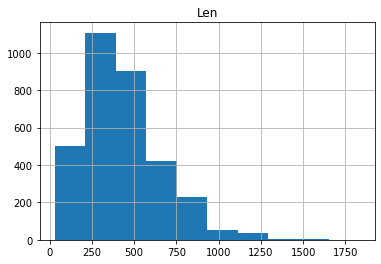

In [34]:
seqsDF = getFragozaSequencesDFs()


In [35]:
seqsDF = seqsDF.reset_index(drop = True)

In [36]:
print (seqsDF.Type.value_counts())

WT    1668
MT    1599
Name: Type, dtype: int64


In [37]:
wtSeqs = seqsDF[seqsDF['Type'] == 'WT'].copy().reset_index(drop = True)

In [38]:
wtSeqs

,ID,Seq,Type
0,84069,MGNSHCVPQAPRRLRASFSRKPSLKGNREDSARMSAGLPGPEAARS...,WT
1,65220,MEMEQEKMTMNKELSPDAAAYCCSACHGDETWSYNHPIRGRAKSRS...,WT
2,339448,MRSRKLTGAVRSSARLKARSCSAARLASAQEVAGSTSAKTACLTSS...,WT
3,64802,MENSEKTEVVLLACGSFNPITNMHLRLFELAKDYMNGTGRYTVVKG...,WT
4,6723,MEPGPDGPAASGPAAIREGWFRETCSLWPGQALSLQVEQLLHHRRS...,WT
...,...,...,...
1663,122183,MEEPRPSKRLRSMAPNQASGGPPPEPGCCVADPEGSVEADGPAQPA...,WT
1664,441521,MTDKTEKVAVDPETVFKRPRECDSPSYQKRQRMALLARKQGAGDSL...,WT
1665,1409,MDVTIQHPWFKRTLGPFYPSRLFDQFFGEGLFEYDLLPFLSSTISP...,WT
1666,51207,MAETSLPELGGEDKATPCPSILELEELLRAGKSSCSRVDEVWPNLF...,WT


In [39]:
actualSeqs = wtSeqs.Seq.to_list()


In [106]:
idsList = getIDs(actualSeqs)
idsList = [x[0] for x in idsList]
idsList = list(set(idsList))

found:  1637  not found:  31  mutli match:  0
total:  1668


In [107]:
#intersect with the CD-Hit seqs 
def getClusterRepIDs(clusterFile):
    #each rep has a * by the name
    reps = []
    with open(clusterFile, "r") as f:
        lines = [x.strip() for x in f.readlines()]
        for l in lines:
            if "*" in l:
                half = l.split(">")[1].translate(str.maketrans('', '', string.punctuation))
                half = half.replace(" ","")
                reps.append(half)
    #change to ints
    reps = [int(x) for x in reps]
    return reps


In [108]:
cdHitIds = getClusterRepIDs("../embedPPI_50_2000_70_Cutoff.clstr")

In [109]:
intersect = set(cdHitIds).intersection(set(idsList))
print (len(cdHitIds))
print (len(idsList))

16614
1636


In [61]:
print (len(intersect))

1354


In [63]:
diff = set(cdHitIds).difference(set(idsList))
print (len(diff))
restOfTestSet = np.random.choice(list(diff), 307)

15260


In [64]:
print (restOfTestSet)

[19351 15878  7793 21229 12019 17038  4522  4159  8621 19537  9181  4064
 12408  6216  5695 14436 10224 15165 13496 15506 13317 13819 21327 18848
 14496  9760  8518 19890 10636 14731 17153 14184 12922  2667  6678 18892
  9805  1291 17731   334   943  6601 14942 10405  4902  2329  3581  6376
 18505 21844 11045 16888 12228  5668 16428 13245  5466 12073 12995  3525
 13265 15110  4857  8723  6103   252 20880 13854 20788 11477 11870  2830
 13673 11947  9549 15066 12431  4632  1091  7025  7280   942 18391  5722
 19649  7203  8767  9219 19305  9147 12218  7289 18647 11696 14336 10170
  7430 13615 10091 17396 18501  2362 12496  6235  6517 15243   121 11501
  7549  5402  6835 15277 15031  7440  9440 14788  9316  1793  6601  5092
 17233 12139  9752  5127  5138 15996  6530 20985 19852  6104  4781 12387
 16564  7434  6235    33 12212 11204 17246 12041  2934  3685  8627 11925
 20664  7047  6851 13388 14476  6434  3436  2555  4726 14194   123 13217
  2422 17199  3515 15270  1128  8680 17944 13933  6

In [110]:
totalTestSet = list(intersect) + list(restOfTestSet)
print (len(totalTestSet))

1661


In [111]:
#save as a txt file 
testSet = open("testSetIDs.txt", "w")
for i in totalTestSet:
    testSet.write(str(i) + "\n" )
testSet.close()

In [114]:
#more training interactions needed 
#use half the fragoza as train, half as test 
halfIntersect = list(np.random.choice(list(set(intersect)), 818))
testSet = open("testSetIDs_halfFragoza.txt", "w")
for i in halfIntersect:
    testSet.write(str(i) + "\n" )
testSet.close()

In [73]:

def getSubsetInteractions(idList):
    # return all interactions where both partners in idList
    conn = db_connect()
    cur = conn.cursor()
    cur.execute("SELECT * FROM interaction")
    ints = cur.fetchall()
    subset = []
    for i in range(0, len(ints)):
        int_potential = ints[i]
        if i%1000 == 0:
            print ("ON: ", i, " OUT OF ", len(ints))
            print (len(subset))
        #check each interaction partners if they are in the list of ids
        #print (int_potential)
        if int_potential[1] in idList and int_potential[2] in idList:
            subset.append(int_potential)
    return subset


def lookAtPositivesAndNegativesCurrent(listIDs):
    # looking at the number of positive examples with the cluster reps
    cdHitSeqs = getClusterRepIDs("embedPPI_50_2000_70_Cutoff.clstr")  # sequence IDs in the DB
    # get all interactions
    subsetGoodFor = getSubsetInteractions(cdHitSeqs)
    positives = [x for x in subsetGoodFor if x[8] != 1]
    print(len(positives))  # 279775
    negatives = [x for x in subsetGoodFor if x[8] == 1 or x[9] == 1]
    print(len(negatives))  # 918
    return positives, negatives


In [79]:
#get subset of total interacitons 
cdHitSeqs = getClusterRepIDs("../embedPPI_50_2000_70_Cutoff.clstr")  # sequence IDs in the DB
# get all interactions
subsetGoodFor = getSubsetInteractions(cdHitSeqs)

ON:  0  OUT OF  757731
0
ON:  1000  OUT OF  757731
563
ON:  2000  OUT OF  757731
1146
ON:  3000  OUT OF  757731
1718
ON:  4000  OUT OF  757731
2312
ON:  5000  OUT OF  757731
2898
ON:  6000  OUT OF  757731
3501
ON:  7000  OUT OF  757731
4071
ON:  8000  OUT OF  757731
4640
ON:  9000  OUT OF  757731
5180
ON:  10000  OUT OF  757731
5721
ON:  11000  OUT OF  757731
6294
ON:  12000  OUT OF  757731
6872
ON:  13000  OUT OF  757731
7464
ON:  14000  OUT OF  757731
8010
ON:  15000  OUT OF  757731
8507
ON:  16000  OUT OF  757731
9057
ON:  17000  OUT OF  757731
9677
ON:  18000  OUT OF  757731
10254
ON:  19000  OUT OF  757731
10830
ON:  20000  OUT OF  757731
11401
ON:  21000  OUT OF  757731
12045
ON:  22000  OUT OF  757731
12646
ON:  23000  OUT OF  757731
13257
ON:  24000  OUT OF  757731
13843
ON:  25000  OUT OF  757731
14443
ON:  26000  OUT OF  757731
15076
ON:  27000  OUT OF  757731
15690
ON:  28000  OUT OF  757731
16313
ON:  29000  OUT OF  757731
16894
ON:  30000  OUT OF  757731
17481
ON:  31000  

ON:  244000  OUT OF  757731
145793
ON:  245000  OUT OF  757731
146482
ON:  246000  OUT OF  757731
147165
ON:  247000  OUT OF  757731
147861
ON:  248000  OUT OF  757731
148452
ON:  249000  OUT OF  757731
149135
ON:  250000  OUT OF  757731
149858
ON:  251000  OUT OF  757731
150553
ON:  252000  OUT OF  757731
151203
ON:  253000  OUT OF  757731
151870
ON:  254000  OUT OF  757731
152504
ON:  255000  OUT OF  757731
153147
ON:  256000  OUT OF  757731
153731
ON:  257000  OUT OF  757731
154380
ON:  258000  OUT OF  757731
154931
ON:  259000  OUT OF  757731
155453
ON:  260000  OUT OF  757731
156126
ON:  261000  OUT OF  757731
156756
ON:  262000  OUT OF  757731
157391
ON:  263000  OUT OF  757731
158075
ON:  264000  OUT OF  757731
158705
ON:  265000  OUT OF  757731
159348
ON:  266000  OUT OF  757731
159977
ON:  267000  OUT OF  757731
160613
ON:  268000  OUT OF  757731
161179
ON:  269000  OUT OF  757731
161636
ON:  270000  OUT OF  757731
162033
ON:  271000  OUT OF  757731
162464
ON:  272000  OUT OF 

ON:  479000  OUT OF  757731
281020
ON:  480000  OUT OF  757731
282020
ON:  481000  OUT OF  757731
283020
ON:  482000  OUT OF  757731
284020
ON:  483000  OUT OF  757731
285020
ON:  484000  OUT OF  757731
286020
ON:  485000  OUT OF  757731
287020
ON:  486000  OUT OF  757731
288020
ON:  487000  OUT OF  757731
289020
ON:  488000  OUT OF  757731
290020
ON:  489000  OUT OF  757731
291020
ON:  490000  OUT OF  757731
292020
ON:  491000  OUT OF  757731
293020
ON:  492000  OUT OF  757731
294020
ON:  493000  OUT OF  757731
295020
ON:  494000  OUT OF  757731
296020
ON:  495000  OUT OF  757731
297020
ON:  496000  OUT OF  757731
298020
ON:  497000  OUT OF  757731
299020
ON:  498000  OUT OF  757731
300020
ON:  499000  OUT OF  757731
301020
ON:  500000  OUT OF  757731
302020
ON:  501000  OUT OF  757731
303020
ON:  502000  OUT OF  757731
304020
ON:  503000  OUT OF  757731
305020
ON:  504000  OUT OF  757731
306020
ON:  505000  OUT OF  757731
307020
ON:  506000  OUT OF  757731
308020
ON:  507000  OUT OF 

ON:  714000  OUT OF  757731
516020
ON:  715000  OUT OF  757731
517020
ON:  716000  OUT OF  757731
518020
ON:  717000  OUT OF  757731
519020
ON:  718000  OUT OF  757731
520020
ON:  719000  OUT OF  757731
521020
ON:  720000  OUT OF  757731
522020
ON:  721000  OUT OF  757731
523020
ON:  722000  OUT OF  757731
524020
ON:  723000  OUT OF  757731
525020
ON:  724000  OUT OF  757731
526020
ON:  725000  OUT OF  757731
527020
ON:  726000  OUT OF  757731
528020
ON:  727000  OUT OF  757731
529020
ON:  728000  OUT OF  757731
530020
ON:  729000  OUT OF  757731
531020
ON:  730000  OUT OF  757731
532020
ON:  731000  OUT OF  757731
533020
ON:  732000  OUT OF  757731
534020
ON:  733000  OUT OF  757731
535020
ON:  734000  OUT OF  757731
536020
ON:  735000  OUT OF  757731
537020
ON:  736000  OUT OF  757731
538020
ON:  737000  OUT OF  757731
539020
ON:  738000  OUT OF  757731
540020
ON:  739000  OUT OF  757731
541020
ON:  740000  OUT OF  757731
542020
ON:  741000  OUT OF  757731
543020
ON:  742000  OUT OF 

In [80]:
print (len(subsetGoodFor))

559751


In [85]:

positives = [x for x in subsetGoodFor if x[8] != 1 and x[10]!= 1]
print (len(positives))

279775


In [87]:

negatives = [x for x in subsetGoodFor if x[8] == 1 or x[10]== 1]
print (len(negatives))

279976


In [98]:
fragozaTest = list(intersect)

In [115]:
def returnSeenType(id1, id2, testIDs):
    #returns interaction type for 3 way split 
    if id1 in testIDs and id2 in testIDs:
        return "DU" #double unseen
    elif id1 in testIDs or id2 in testIDs:
        return "OU" #one unseen
    else:
        return "DS" #double seen

asDF = {'1':[], '2':[], 'Interacts':[], 'Type':[]}
for x in subsetGoodFor:
    asDF['1'].append(x[1])
    asDF['2'].append(x[2])
    if x[8] != 1 and x[10]!= 1:
        asDF['Interacts'].append(1)
    else:
        asDF['Interacts'].append(0)
    #splitting into 3 groupings
    asDF['Type'].append(returnSeenType(x[1], x[2], halfIntersect))

In [116]:
asDF = pd.DataFrame(asDF)

In [117]:
asDF

,1,2,Interacts,Type
0,4785,11753,1,DS
1,15855,17197,1,OU
2,5902,9419,1,DS
3,13206,15491,1,DS
4,15797,15797,1,DS
...,...,...,...,...
559746,11746,20403,0,DS
559747,3664,19757,0,DS
559748,3971,18932,0,DS
559749,83,11457,0,DS


In [118]:
print (asDF.Type.value_counts())
#breakdowns 
print ("positives")
print (asDF[asDF['Interacts'] == 1].Type.value_counts())
print ('negatives')
print (asDF[asDF['Interacts'] == 0].Type.value_counts())

DS    458282
OU     94709
DU      6760
Name: Type, dtype: int64
positives
DS    239259
OU     37918
DU      2598
Name: Type, dtype: int64
negatives
DS    219023
OU     56791
DU      4162
Name: Type, dtype: int64


In [123]:
#marking interactions by train/validation/test splits for 3 way training 
asDF['Dataset'] = [None] * asDF.shape[0]
totalValidOU = 0 #goal is 47354
totaltestOU = 0 #goal is 47355
totalValidDU = 0 #goal is 3380
totalTtestDU = 0 #goal is 3380

for ind, row in asDF.iterrows():
    if row['Type'] == 'DS':
        asDF.at[ind, 'Dataset'] = 'Train'
    elif row['Type'] == 'OU':
        #fill validation first 
        if totalValidOU < 47354:
            asDF.at[ind, 'Dataset'] = 'Valid'
            totalValidOU += 1
        if totalValidOU == 47354:
            asDF.at[ind, 'Dataset'] = 'Test'
    elif row['Type'] == 'DU':
        if totalValidDU < 3380:
            asDF.at[ind, 'Dataset'] = 'Valid'
            totalValidDU += 1
        if totalValidDU == 3380:
            asDF.at[ind, 'Dataset'] = 'Test'

In [124]:
asDF

,1,2,Interacts,Type,Dataset
0,4785,11753,1,DS,Train
1,15855,17197,1,OU,Valid
2,5902,9419,1,DS,Train
3,13206,15491,1,DS,Train
4,15797,15797,1,DS,Train
...,...,...,...,...,...
559746,11746,20403,0,DS,Train
559747,3664,19757,0,DS,Train
559748,3971,18932,0,DS,Train
559749,83,11457,0,DS,Train


In [125]:
print (asDF.Dataset.value_counts())

Train    458282
Test      50737
Valid     50732
Name: Dataset, dtype: int64


In [126]:
asDF.to_csv("halfFragozaTestSet.csv")

In [130]:
#now make random sample dataset version 

asDF = {'1':[], '2':[], 'Interacts':[]}
for x in subsetGoodFor:
    asDF['1'].append(x[1])
    asDF['2'].append(x[2])
    if x[8] != 1 and x[10]!= 1:
        asDF['Interacts'].append(1)
    else:
        asDF['Interacts'].append(0)
    

In [133]:
asDFRS = pd.DataFrame(asDF)
asDFRS['Dataset'] = [None] * asDFRS.shape[0]

In [135]:
#now randomly assign train/validation/test splits of same size to df
indices = list(range(0, asDFRS.shape[0]))
#shuffle and split 
random.shuffle(indices)
train = indices[0:458282]
for ind in train:
    asDFRS.at[ind, 'Dataset'] = 'Train'
validation = indices[458282 + 1: 458282 + 50737]
for ind in validation:
    asDFRS.at[ind, 'Dataset'] = 'Valid'
test = indices[-50732:]
for ind in test:
    asDFRS.at[ind, 'Dataset'] = 'Test'

In [138]:
asDFRS
print (asDFRS.Dataset.value_counts())

Train    458282
Valid     50736
Test      50732
Name: Dataset, dtype: int64


In [139]:
asDFRS.to_csv("randomBreakup.csv")

In [144]:

def getIDsTotal(proList):
    #returns list of database ids where possible
    ids = []
    foundIds = 0
    notFound = 0
    multiMatch = 0
    conn = db_connect()
    cur = conn.cursor()
    for seq in proList:
        cur.execute("SELECT * FROM proteins WHERE sequence=?", (seq,))
        found =  cur.fetchall()
        if len(found) == 0: #not found 
            notFound += 1
            ids.append(0)
        elif len(found) == 1:
            foundIds += 1
            ids.append(found[0][0])
        else:
            multiMatch += 1
    print ("found: ", foundIds, " not found: ", notFound, " mutli match: ", multiMatch)
    print ("total: ",len(proList))
    return ids 
wtSeqs = seqsDF[seqsDF['Type'] == 'WT'].copy().reset_index(drop = True)
idsList = getIDsTotal(actualSeqs)
wtSeqs['ppiDB'] = idsList

found:  1637  not found:  31  mutli match:  0
total:  1668


In [185]:
#setup Fragoza mutant testset 
#for 3-way split, mark which MT are in the test half 
def getFragozaInteractionDFs(idMap, listTestIds):
    #returns csv of interactions and sequences below <= 2000 AA
    # attaching NP to each row
    origDatasetDtypes = {
        "Chrom": str,
        "Pos": float,
        "dbSNP_id": str,
        "Mutation": str,
        "AF_all": float,
        "Target Entrez GeneID": str,
        "HGVS_cDNA": str,
        "UniProt": str,
        "Interactor Entrez GeneID": str,
        "Disruption": float,
    }
    # print (origDatasetDtypes)
    origDataset = pd.read_csv("41467_2019_11959_MOESM6_ESM.csv", sep=',')
    origDataset = origDataset.astype(origDatasetDtypes)

    origDataset['transcript'] = origDataset.apply(lambda row: row['HGVS_cDNA'].split(':')[0], axis=1)
    origDataset['mutationAA'] = origDataset.apply(lambda row: row['UniProt'].split(',')[1], axis=1)

    openedKey = pd.read_csv("transcriptProteinTableFragoza.csv")
    merged = pd.merge(origDataset, openedKey, how='left', on='transcript')
    merged['saveIDTarget'] = merged['Target Entrez GeneID'] + "_" + merged['mutationAA']
    print ("intermed length: ", merged.shape) #(4109, 15)
    seqTable = {"ID": [], "Seq": [], 'Len': [], 'PPIDB':[]}
    # saveIDTarget (mutation partner) mut id
    # "Interactor Entrez GeneID" other
    print(merged.iloc[0])
    badMutants = []
    for i, row in merged.iterrows():
        # open orig FASTA
        origID = row['Target Entrez GeneID']
        mutation = row['mutationAA']
        np = row['product']
        fastaFolder = './FragozaFastas/'
        mutationU = row['UniProt']
        saveID = row['saveIDTarget']
        fastaName = fastaFolder + np + ".fa"
        newSeq = mutateSequence(fastaName, mutationU)
        wtSeq = openFasta(fastaName)
        idMapID = idMap[idMap['Seq'] == wtSeq]['ppiDB']
        if not idMapID.empty:
            #print (idMapID)
            #print (idMapID.values[0])
            aID = idMapID.values[0]
            if not newSeq == -1:
                seqTable["ID"].append(saveID)
                seqTable["Seq"].append(newSeq)
                seqTable['Len'].append(len(newSeq))
                seqTable['PPIDB'].append(aID)
            else:
                #print("Bad mutation")
                badMutants.append(saveID)
            if len(wtSeq) > 1:
                seqTable["ID"].append(origID)
                seqTable["Seq"].append(wtSeq)
                seqTable['Len'].append(len(wtSeq))
                seqTable['PPIDB'].append(aID)

    badNamesInteractors = [122183, 441521, 1409, 51207, 9465]

    # saving those interactor wt to a dataframe
    uniprotInteractors = pd.read_csv("withIDsInteractorUniprot.tab", sep='\t')
    # now for each not in the bad set, get the seqT
    for i, row in uniprotInteractors.iterrows():
        idInt = row['yourlist']
        sequence = row['Sequence']
        if idInt not in badNamesInteractors:
            idMapID = idMap[idMap['Seq'] == sequence]['ppiDB']
            if not idMapID.empty:
                #print (idMapID)
                #print (idMapID.values[0])
                aID = idMapID.values[0]
                seqTable['ID'].append(idInt)
                seqTable['Seq'].append(sequence)
                seqTable['Len'].append(len(sequence))
                seqTable['PPIDB'].append(aID)

    badInteractors = ['390535', '541471', '729862', '202459', '155060', '401508', '80028']
    goodInteractors = [10597, 285733, 145946, 440184, 440321, 9753, 122183, 441521, 1409, 51207, 9465]

    for interactors in goodInteractors:
        fastaName = "./FragozaInteractors/" + str(interactors) + ".fasta"
        fastaSeq = openFasta(fastaName)
        idMapID = idMap[idMap['Seq'] == fastaSeq]['ppiDB']
        if not idMapID.empty:
            #print (idMapID)
            #print (idMapID.values[0])
            aID = idMapID.values[0]
            seqTable['Seq'].append(fastaSeq)
            seqTable['ID'].append(interactors)
            seqTable['Len'].append(len(fastaSeq))
            seqTable['PPIDB'].append(aID)

    asDF = pd.DataFrame(seqTable)
    print(asDF.drop_duplicates())

    # save as CSV
    # trim lengths here
    #print(asDF.shape)
    #print (asDF)
    #distribution of sequence lengths:
    asDF = asDF.drop_duplicates()
    print ("total sequences: ", asDF.shape)
    asDF = asDF[asDF['Len'] <= 2000]
    asDF = asDF.drop_duplicates()
    print ("below 2000 AA: ", asDF.shape)

    #total sequences:  (8927, 3)
    #below 2000 AA:  (8898, 3)

    print(asDF.shape)
    passedIDS = asDF['ID'].to_list()
    hist = asDF.hist()
    plt.show()
    asDF = asDF.drop(['Len'], axis=1)

    PIPRPairs = {'v1': [], 'ppiDB1':[], 'v2': [], 'ppiDB2':[], 'label': [], 'type': [], 'set':[]}  # 1 if interacts, 0 else
    for i, row in merged.iterrows():
        # open orig FASTA
        #print (row)
        origID = row['Target Entrez GeneID']  # wt 1
        saveID = row['saveIDTarget']  # mt 1
        wtID2 = row["Interactor Entrez GeneID"]
        if wtID2 in passedIDS and origID in passedIDS and saveID in passedIDS:
            disruption = row['Disruption']  # 0 if nondisrupting, 1 if disrupting
            ppiDB = asDF[asDF['ID'] == origID].PPIDB.values[0]
            #print (ppiDB)
            ppiDB2 = asDF[asDF['ID'] == wtID2].PPIDB.values[0]
            #print (ppiDB2)
            #WT
            PIPRPairs['v1'].append(origID)
            PIPRPairs['ppiDB1'].append(ppiDB)
            PIPRPairs['v2'].append(wtID2)
            PIPRPairs['label'].append(1)
            PIPRPairs['type'].append("WT")
            #MT
            PIPRPairs['ppiDB2'].append(ppiDB2)
            PIPRPairs['v1'].append(saveID)
            PIPRPairs['ppiDB1'].append(ppiDB)
            PIPRPairs['v2'].append(wtID2)
            PIPRPairs['ppiDB2'].append(ppiDB2)
            PIPRPairs['label'].append(flipDisruption(disruption))
            PIPRPairs['type'].append("MT")
            
            if (ppiDB in listTestIds) and (ppiDB2 in listTestIds):
                PIPRPairs['set'].append('Unseen')
                PIPRPairs['set'].append('Unseen')
            elif ppiDB in listTestIds or ppiDB2 in listTestIds:
                PIPRPairs['set'].append('One Unseen')
                PIPRPairs['set'].append('One Unseen')
            else:
                PIPRPairs['set'].append('Seen')
                PIPRPairs['set'].append('Seen')
    # 868 non disruptive mutants, 195 disrutpive

    piprDF = pd.DataFrame(PIPRPairs)
    piprDF = piprDF.drop_duplicates()
    print("TOTAL SIZE: ", piprDF.shape)

    # save only WT
    piprDFWT = piprDF[piprDF['type'] == 'WT']
    print("WT: ", piprDFWT.shape)
    piprDFWT = piprDFWT.drop(['type'], axis=1)
    piprDFWT.to_csv("wtFragoza.tab", sep="\t", header=True, index=False)
    # save only MT
    # save only WT
    piprDFMT = piprDF[piprDF['type'] == 'MT']
    print("MT: ", piprDFMT.shape)
    piprDFWT = piprDFMT.drop(['type'], axis=1)
    piprDFWT.to_csv("mtFragoza.tab", sep="\t", header=True, index=False)

    #number disruptive vs not
    print (piprDF.label.value_counts())
    """
    #1    2073
    #0     255
    """
    #mt disruptions
    print ("MT disruptions: ")
    print (piprDFMT.label.value_counts())
    """
    #1    1308
    #0     255
    """
    #piprDF = piprDF.drop(['type'], axis=1)

    return asDF, piprDF

In [145]:
wtSeqs

,ID,Seq,Type,ppiDB
0,84069,MGNSHCVPQAPRRLRASFSRKPSLKGNREDSARMSAGLPGPEAARS...,WT,4804
1,65220,MEMEQEKMTMNKELSPDAAAYCCSACHGDETWSYNHPIRGRAKSRS...,WT,14400
2,339448,MRSRKLTGAVRSSARLKARSCSAARLASAQEVAGSTSAKTACLTSS...,WT,12918
3,64802,MENSEKTEVVLLACGSFNPITNMHLRLFELAKDYMNGTGRYTVVKG...,WT,3569
4,6723,MEPGPDGPAASGPAAIREGWFRETCSLWPGQALSLQVEQLLHHRRS...,WT,4449
...,...,...,...,...
1663,122183,MEEPRPSKRLRSMAPNQASGGPPPEPGCCVADPEGSVEADGPAQPA...,WT,5998
1664,441521,MTDKTEKVAVDPETVFKRPRECDSPSYQKRQRMALLARKQGAGDSL...,WT,4442
1665,1409,MDVTIQHPWFKRTLGPFYPSRLFDQFFGEGLFEYDLLPFLSSTISP...,WT,411
1666,51207,MAETSLPELGGEDKATPCPSILELEELLRAGKSSCSRVDEVWPNLF...,WT,14358


intermed length:  (4109, 15)
Chrom                                              1
Pos                                           909238
dbSNP_id                                   rs3829740
Mutation                                         G>C
AF_all                                       0.66855
Target Entrez GeneID                           84069
HGVS_cDNA                   NM_001160184.1:c.1355G>C
UniProt                                 Q494U1,R539P
Interactor Entrez GeneID                        5966
Disruption                                         0
transcript                            NM_001160184.1
mutationAA                                     R539P
number products                                    1
product                               NP_001153656.1
saveIDTarget                             84069_R539P
Name: 0, dtype: object
                ID                                                Seq  Len  \
0      84069_R539P  MGNSHCVPQAPRRLRASFSRKPSLKGNREDSARMSAGLPGPEAARS...  576 

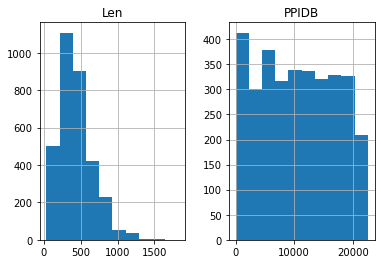

TOTAL SIZE:  (2328, 7)
WT:  (765, 7)
MT:  (1563, 7)
1    2073
0     255
Name: label, dtype: int64
MT disruptions: 
1    1308
0     255
Name: label, dtype: int64


In [186]:
#have matched up seqs to ids 
asDF, piprDF = interactions = getFragozaInteractionDFs(wtSeqs, halfIntersect)

In [187]:
piprDF.set.value_counts()

One Unseen    996
Seen          948
Unseen        384
Name: set, dtype: int64

In [189]:
piprDF.to_csv("FragozaSetSplit.csv")